In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [19]:
import import_ipynb
import model

Matrix([[theta], [omega], [position], [speed]])
Matrix([[omega], [(-Kt*(theta - 2*pi*position/pitch) - bm*omega + tau)/Jm], [speed], [(2*pi*Kt*(theta - 2*pi*position/pitch)/pitch - bt*speed)/Mt]])


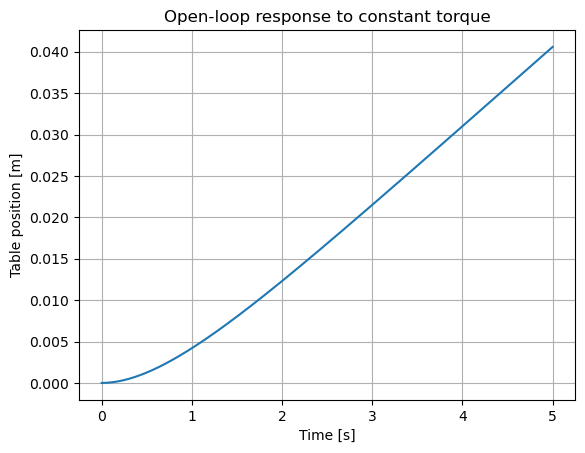

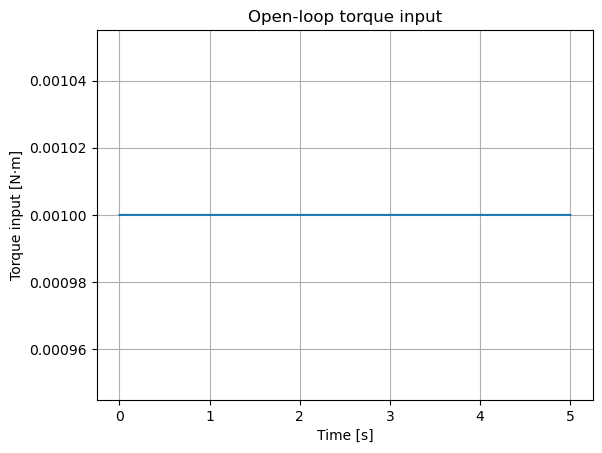

max position = 0.0405813153612657
final position = 0.0405813153612657
[[-1.17043598e+00  1.50836826e-02  1.82692595e+03  3.75331511e-01]]


/var/folders/xj/s_t94s8n46xgmygg7rb3ff4c0000gn/T/ipykernel_24550/2423721397.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = float(Cpos @ x)
/var/folders/xj/s_t94s8n46xgmygg7rb3ff4c0000gn/T/ipykernel_24550/2423721397.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x + N_r * x_ref)


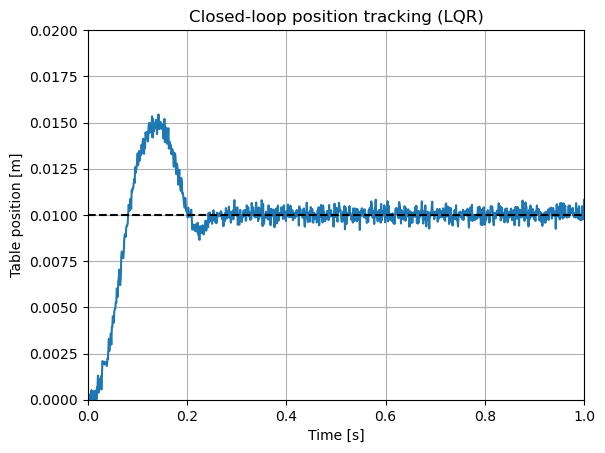

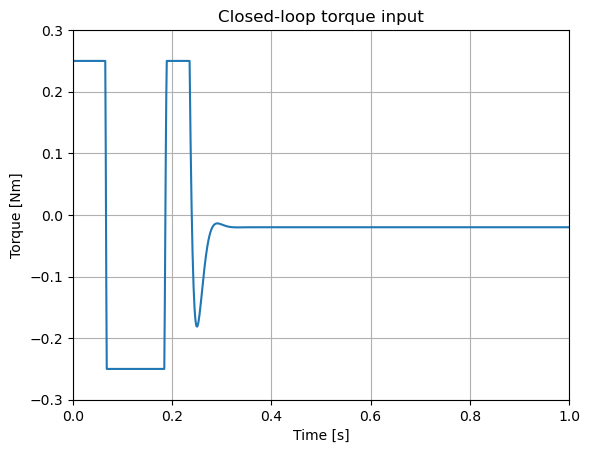

A: [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.00000000e+09 -1.00000000e+00  3.92699082e+12  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.96349541e+08  0.00000000e+00 -1.54212569e+11 -1.00000000e+01]]
B: [[    0.]
 [10000.]
 [    0.]
 [    0.]]
Ad: [[ 9.37085710e-01  9.67972013e-04  4.94127678e+01  2.46512487e-02]
 [ 4.01295985e+02  9.36117738e-01 -3.15177129e+05  4.91662553e+01]
 [ 2.45954533e-03  1.23256243e-06 -9.31722384e-01  3.13065728e-05]
 [-1.57809813e+01  2.45831277e-03  1.23943537e+04 -9.32035450e-01]]
Bd: [[4.84091125e-03]
 [9.67972013e+00]
 [6.16347943e-06]
 [1.23256243e-02]]


In [3]:
# Temporary Cell for Juanacho to import model
from types import SimpleNamespace
from pathlib import Path

# 1) Run the model notebook into this kernel
#    (if it's in the same folder, ./model.ipynb is correct)
get_ipython().run_line_magic("run", " -i ./model.ipynb")

# 2) Pack needed symbols into a 'model' namespace so downstream code can do model.Ad, model.Ts, etc.
model = SimpleNamespace(
    Ad=Ad, Bd=Bd, Cd=Cd, Dd=Dd,
    Ts=Ts,
    K_lqr=K_lqr, N_r=N_r
)

In [4]:
def parse_gcode_lines(lines):
    """
    Parse a subset of G-code:
    - G0 / G1 moves
    - X coordinate (mm)
    - F feedrate (mm/min)

    Returns list of (x_start_m, x_end_m, feed_m_per_s).
    """
    moves = []
    x_curr_mm = 0.0
    feed_default_mm_min = 600.0  # default feed if F not specified

    for raw in lines:
        line = raw.strip()
        if not line or line.startswith(";") or line.startswith("("):
            continue

        if line.startswith("G0") or line.startswith("G1"):
            parts = line.split()
            x_new_mm = x_curr_mm
            F_mm_min = feed_default_mm_min

            for p in parts:
                if p.startswith("X"):
                    # X10.0 -> 10.0
                    x_new_mm = float(p[1:])
                elif p.startswith("F"):
                    F_mm_min = float(p[1:])

            # convert to meters and m/s
            x0_m = x_curr_mm / 1000.0
            x1_m = x_new_mm / 1000.0
            v_feed = (F_mm_min / 1000.0) / 60.0  # mm/min -> m/s

            moves.append((x0_m, x1_m, v_feed))
            x_curr_mm = x_new_mm

    return moves


In [5]:
# Parser Example

gcode_example = [
    "G1 X10.0 F600",
    "G1 X25.0",
    "G0 X0.0 F1200",
]

parse_gcode_lines(gcode_example)


[(0.0, 0.01, 0.01), (0.01, 0.025, 0.01), (0.025, 0.0, 0.02)]

In [6]:
# Trapezoid generation for S-Curve
def generate_trapezoid_velocity_segment(x0, x1, v_cmd, Ts, a_max=0.5):
    """
    Build the *velocity* trapezoid/triangle between x0 and x1 (signed with motion direction).
    Returns (t, v). We will smooth v with a jerk limiter and then integrate to position.
    """
   
    dist = x1 - x0
    direction = np.sign(dist) if dist != 0 else 1.0
    L = abs(dist)
    if L == 0:
        return np.array([0.0]), np.array([0.0])

    v_abs = abs(v_cmd)
    t_acc = v_abs / a_max
    d_acc = 0.5 * a_max * t_acc**2

    if 2*d_acc >= L:
        # Triangular case
        t1 = np.sqrt(L / a_max)
        t_total = 2*t1
        t = np.arange(0.0, t_total + 1e-12, Ts)
        v = np.where(t <= t1, a_max*t, a_max*(t_total - t))
        v = np.maximum(v, 0.0) * direction
        return t, v
    else:
        # Trapezoid case
        d_cruise = L - 2*d_acc
        t_cruise = d_cruise / v_abs
        t_total = 2*t_acc + t_cruise
        t = np.arange(0.0, t_total + 1e-12, Ts)
        v = np.zeros_like(t)
        for k, tk in enumerate(t):
            if tk <= t_acc:
                v[k] = a_max * tk
            elif tk <= t_acc + t_cruise:
                v[k] = v_abs
            else:
                t_dec = tk - (t_acc + t_cruise)
                v[k] = max(v_abs - a_max * t_dec, 0.0)
        v *= direction
        return t, v


def apply_jerk_limiter_to_velocity(v_in, Ts, j_max):
    """
    Limit jerk by bounding the *change in acceleration* each step.
    Input: v_in[k] (raw trapezoid velocity)
    Output: v_out[k] (jerk-limited, S-curve velocity)
    """
    import numpy as np

    v_in = np.asarray(v_in, dtype=float)
    v_out = np.zeros_like(v_in)
    v_out[0] = v_in[0]
    a_prev = 0.0

    for k in range(1, len(v_in)):
        a_des = (v_in[k] - v_out[k-1]) / Ts     # accel we’d need to hit raw v_in
        da = a_des - a_prev                     # change in accel (jerk * dt)
        da = np.clip(da, -j_max*Ts, j_max*Ts)   # bound jerk
        a = a_prev + da
        v_out[k] = v_out[k-1] + a*Ts
        a_prev = a

    return v_out


def integrate_velocity_to_position(x0, v, Ts):
    """
    Integrate velocity to position (rectangle rule). Keeps the interface as x[k].
    """
    import numpy as np

    x = np.zeros_like(v)
    x[0] = x0
    for k in range(1, len(v)):
        x[k] = x[k-1] + v[k-1]*Ts
    return x


In [7]:
def generate_trapezoid_segment(x0, x1, v_cmd, Ts, a_max=0.5):
    """
    Generate a trapezoidal (or triangular) velocity profile between x0 and x1
    with commanded cruise speed v_cmd [m/s] and max acceleration a_max [m/s^2].
    Returns t_seg, x_seg.
    """
    dist = x1 - x0
    direction = np.sign(dist) if dist != 0 else 1.0
    L = abs(dist)

    if L == 0:
        return np.array([0.0]), np.array([x0])

    v_cmd = abs(v_cmd) * direction  # sign with direction
    v_abs = abs(v_cmd)

    # time to accelerate to v_cmd
    t_acc = v_abs / a_max
    d_acc = 0.5 * a_max * t_acc**2

    if 2 * d_acc >= L:
        # cannot reach v_cmd -> triangular profile
        v_peak = np.sqrt(L * a_max)
        t_acc = v_peak / a_max
        t_cruise = 0.0
    else:
        # true trapezoid
        d_cruise = L - 2 * d_acc
        t_cruise = d_cruise / v_abs

    t_total = 2 * t_acc + t_cruise
    N = int(np.round(t_total / Ts)) + 1
    t = Ts * np.arange(N)

    x = np.zeros(N)
    x[0] = x0

    for k in range(1, N):
        tk = t[k]

        if tk <= t_acc:
            # accel phase
            v = a_max * tk
        elif tk <= t_acc + t_cruise:
            # cruise
            v = v_abs
        else:
            # decel
            t_dec = tk - (t_acc + t_cruise)
            v = max(v_abs - a_max * t_dec, 0.0)

        v *= direction
        x[k] = x[k-1] + v * Ts

    # shift final point exactly to x1 to avoid drift
    x[-1] = x1

    return t, x


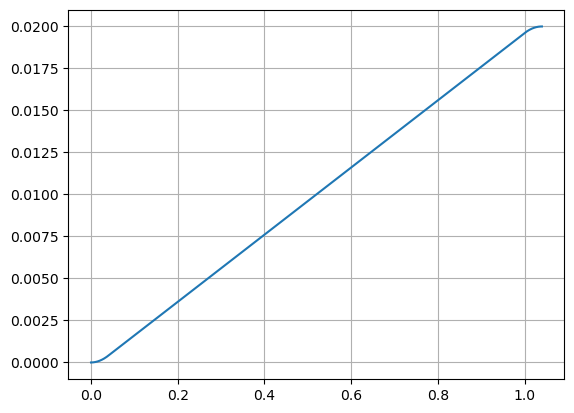

In [8]:
# Test

Ts = model.Ts  # from model
t_seg, x_seg = generate_trapezoid_segment(0.0, 0.02, 0.02, Ts)  # 2 cm move at 2 cm/s
plt.plot(t_seg, x_seg)
plt.grid(True)


In [9]:
def build_trajectory_from_gcode(lines, Ts, a_max=0.5):
    """
    Parse G-code lines and build a full reference trajectory x_ref[k].
    Returns t_all, x_ref_all.
    """
    moves = parse_gcode_lines(lines)

    t_all = []
    x_all = []

    t_offset = 0.0
    first = True

    for (x0, x1, v_feed) in moves:
        t_seg, x_seg = generate_trapezoid_segment(x0, x1, v_feed, Ts, a_max=a_max)

        if first:
            t_all.append(t_seg)
            x_all.append(x_seg)
            first = False
        else:
            # skip first sample to avoid duplicate timestamps at junction
            t_all.append(t_offset + t_seg[1:])
            x_all.append(x_seg[1:])

        t_offset = t_all[-1][-1]

    if not t_all:
        return np.array([]), np.array([])

    t_full = np.concatenate(t_all)
    x_full = np.concatenate(x_all)

    return t_full, x_full


In [10]:
# S-Curve Builder
def build_trajectory_from_gcode_scurve(lines, Ts, a_max=0.5, j_max=5.0):
    """
    Build a *jerk-limited* (S-curve) reference from G-code:
      1) Make velocity profiles per segment (trapezoid/triangle) -> (t, v)
      2) Concatenate all v blocks into one v_full timeline
      3) Apply jerk limit on v_full (bounds jerk at j_max)
      4) Integrate v to x to get x_ref[k]
    Returns: t_full, x_full
    """

    moves = parse_gcode_lines(lines)
    if not moves:
        return np.array([]), np.array([])

    t_blocks, v_blocks = [], []
    t_offset = 0.0
    first = True
    x0_global = moves[0][0]  # starting position for integration

    for (x0, x1, v_feed) in moves:
        t_seg, v_seg = generate_trapezoid_velocity_segment(x0, x1, v_feed, Ts, a_max=a_max)
        if first:
            t_blocks.append(t_seg)
            v_blocks.append(v_seg)
            t_offset = t_seg[-1]
            first = False
        else:
            # avoid duplicate time sample at segment junctions
            t_blocks.append(t_offset + t_seg[1:])
            v_blocks.append(v_seg[1:])
            t_offset = t_blocks[-1][-1]

    t_full = np.concatenate(t_blocks)
    v_full = np.concatenate(v_blocks)

    # jerk-limit velocity timeline and integrate to position
    v_smooth = apply_jerk_limiter_to_velocity(v_full, Ts, j_max=j_max)
    x_full = integrate_velocity_to_position(x0_global, v_smooth, Ts)
    return t_full, x_full


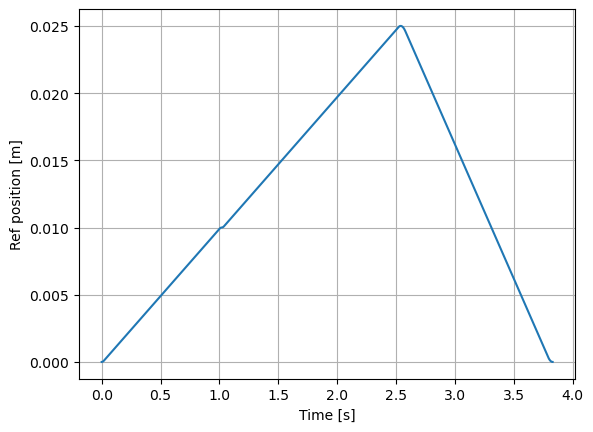

In [11]:
# Test

t_traj, x_traj = build_trajectory_from_gcode(gcode_example, Ts=model.Ts)
plt.figure()
plt.plot(t_traj, x_traj)
plt.xlabel("Time [s]")
plt.ylabel("Ref position [m]")
plt.grid(True)


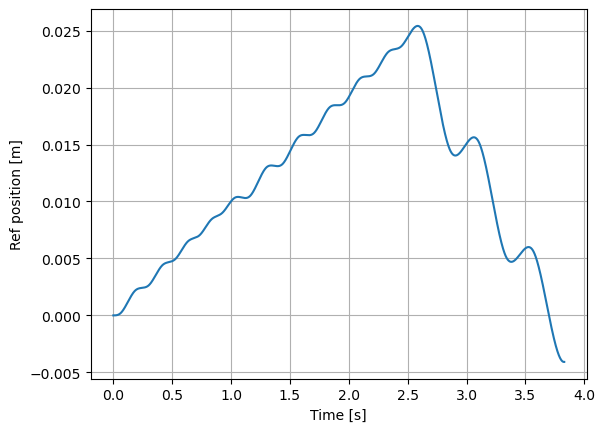

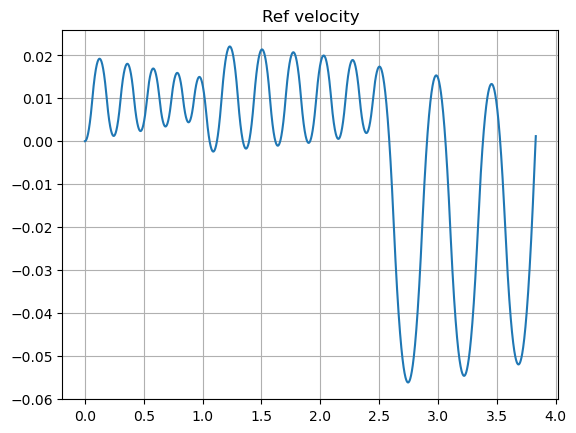

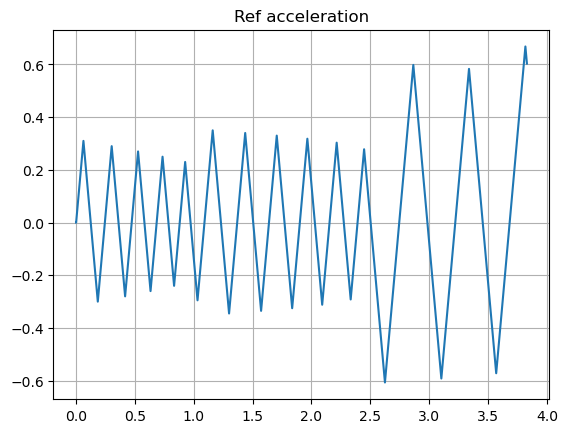

In [12]:
# S-Curve Test

t_traj, x_traj = build_trajectory_from_gcode_scurve(
    gcode_example,
    Ts=model.Ts,
    a_max=0.5,   # same accel cap used before
    j_max=5.0    # pick a jerk cap; tune 3–20 m/s^3 as a starting range
)
plt.figure()
plt.plot(t_traj, x_traj)
plt.xlabel("Time [s]")
plt.ylabel("Ref position [m]")
plt.grid(True)

# Difference in Velocity and Acceleration Plots between Trapezoid and S-Curve Implementations
v_ref = np.diff(x_traj, prepend=x_traj[0]) / model.Ts
a_ref = np.diff(v_ref, prepend=v_ref[0]) / model.Ts
plt.figure(); plt.plot(t_traj, v_ref); plt.title("Ref velocity"); plt.grid(True)
plt.figure(); plt.plot(t_traj, a_ref); plt.title("Ref acceleration"); plt.grid(True)


In [13]:
def simulate_closed_loop_trajectory(x_ref_traj, Ts, u_max=0.25):
    """
    Follow a time-varying reference trajectory x_ref_traj[k]
    using the LQR controller from model.py.
    Uses the same noise/disturbance toggles as the model's single-step sim.
    """

    Ad = model.Ad
    Bd = model.Bd
    K  = model.K_lqr
    N_r = model.N_r

    N_steps = len(x_ref_traj)
    n = Ad.shape[0]

    x = np.zeros((n, 1))

    xs = np.zeros((N_steps, n))
    ys = np.zeros(N_steps)
    us = np.zeros(N_steps)

    Cpos = np.array([[0., 0., 1., 0.]])

    for k in range(N_steps):
        x_ref = x_ref_traj[k]

        # true output
        y_true = float(Cpos @ x)
        y_meas = y_true

        # you can later pull model. USE_SENSOR_NOISE etc. if wanted
        u = float(-K @ x + N_r * x_ref)
        u = np.clip(u, -u_max, u_max)

        x = Ad @ x + Bd * u

        xs[k, :] = x.ravel()
        ys[k]    = y_true
        us[k]    = u

    t = Ts * np.arange(N_steps)
    return t, xs, ys, us


/var/folders/xj/s_t94s8n46xgmygg7rb3ff4c0000gn/T/ipykernel_24550/3293258180.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = float(Cpos @ x)
/var/folders/xj/s_t94s8n46xgmygg7rb3ff4c0000gn/T/ipykernel_24550/3293258180.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x + N_r * x_ref)


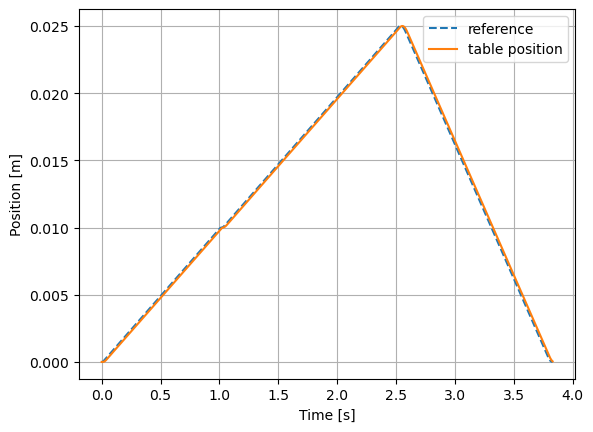

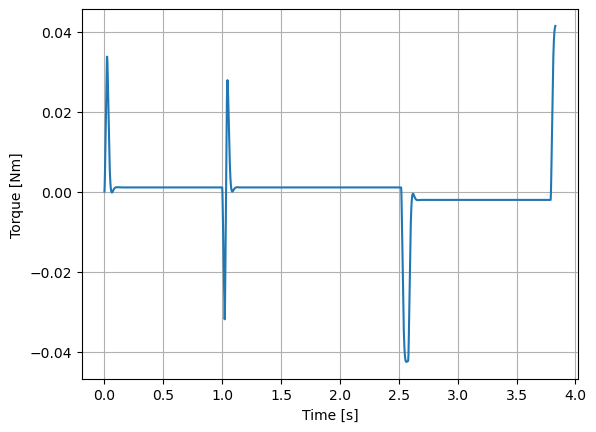

In [14]:
# fake G-code program
gcode_example = [
    "G1 X10.0 F600",
    "G1 X25.0 F600",
    "G0 X0.0 F1200",
]

# build trajectory
Ts = model.Ts
t_traj, x_traj = build_trajectory_from_gcode(gcode_example, Ts)

# simulate closed-loop tracking
t, xs, ys, us = simulate_closed_loop_trajectory(x_traj, Ts, u_max=0.25)

plt.figure()
plt.plot(t_traj, x_traj, '--', label='reference')
plt.plot(t, ys, label='table position')
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, us)
plt.xlabel("Time [s]")
plt.ylabel("Torque [Nm]")
plt.grid(True)
